# Model-Based RL: Policy and Value Iteration using Dynamic Programming

We are going to use openai gym FrozenLake8x8 environment to implement two dynamic programming algorithms : Policy iteration and value iteration.

Dynamic Programming (DP) methods assume that we have a perfect model of the environment's Markov Decision Process (MDP). That's usually not the case in practice, but it's important to study DP anyway.

In [18]:
import random
import time
import numpy as np 
import gym
from IPython.display import clear_output

import matplotlib.pyplot as plt 
%matplotlib inline

Let's start by loading our environment

In [2]:
env = gym.make("FrozenLake8x8-v0")

The agent controls the movement of a character in a grid world. Some tiles of the grid are walkable, and others lead to the agent falling into the water. Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction. The agent is rewarded for finding a walkable path to a goal tile.

Winter is here. You and your friends were tossing around a frisbee at the park when you made a wild throw that left the frisbee out in the middle of the lake. The water is mostly frozen, but there are a few holes where the ice has melted. If you step into one of those holes, you'll fall into the freezing water. At this time, there's an international frisbee shortage, so it's absolutely imperative that you navigate across the lake and retrieve the disc. However, the ice is slippery, so you won't always move in the direction you intend.

The surface is described using a grid like the following:

SFFF       (S: starting point, safe)\
FHFH       (F: frozen surface, safe)\
FFFH       (H: hole, fall to your doom)\
HFFG       (G: goal, where the frisbee is located)\

The episode ends when you reach the goal or fall in a hole. You receive a reward of 1 if you reach the goal, and zero otherwise.

In [8]:
gamma = 0.95
tol = 1e-4

## utility functions

Before training the agent, we need to have some utility functions. The first function takes a policy as a parameter and evaluates it by calculating the success rate ( the agent reaching the goal without falling in a hole )

In [33]:
def stats(env, pi, episodes=1000):
    success = 0
    for episode in range(episodes):
        done = False
        s = env.reset()
        while not done:
            a = pi[s]
            s, reward , done, _ = env.step(a)
        if reward:
            success += 1
    return {"success" : success, "failure" : episodes - success, "rate" : success / episodes, "episodes" : episodes}

This function takes a value array as a parameter and visualize it in a 2D plot

In [24]:
def plot_value(v):
    plt.figure(figsize=(10,8))
    plt.imshow(v.reshape(8,8))
    plt.colorbar()
    plt.title("value function")
    plt.show()

This function uses the trained policy to play the game a certain number of episodes

In [29]:
def play(env, pi, episodes=3):
    for episode in range(episodes):
        done = False
        s = env.reset()
        time.sleep(1)
        while not done:
            a = pi[s]
            s, _ , done, _ = env.step(a)
            print("EPISODE ",episode + 1,"\n")
            env.render()
            time.sleep(0.2)
            clear_output(True)
        time.sleep(1)

## 1. Policy iteration

In [35]:
def one_step_lookahead(env, v, s, a):
    ans = 0  
    for prob, next_state, reward, _ in env.P[s][a]:
        ans += prob * (reward + gamma * v[next_state])
    return ans

In [36]:
def policy_evaluation(env, pi, v):
    while True:
        delta = 0
        for s in range(env.nS):
            temp = v[s]
            v[s] = one_step_lookahead(env, v, s, pi[s])
            delta = max(delta, abs(v[s]-temp))
        if delta < tol:
            break
    return v

In [37]:
def policy_improvement(env, pi, v):
    stable = True
    for s in range(env.nS):
        temp = pi[s]
        # pick the action with highest value
        cur = pi[s]
        m = 0
        for a in range(env.nA):
            x = one_step_lookahead(env, v, s, a)
            if(x > m):
                m = x 
                cur = a 
        pi[s] = cur
        if temp != pi[s]:
            stable = False
    return pi, stable

In [38]:
def policy_iteration(env):
    stable = False
    v = np.zeros(env.nS)
    pi = np.zeros(env.nS,int)
    while not stable:
        v = policy_evaluation(env, pi, v)
        pi, stable = policy_improvement(env, pi, v)
    return v, pi

In [39]:
v, pi = policy_iteration(env)

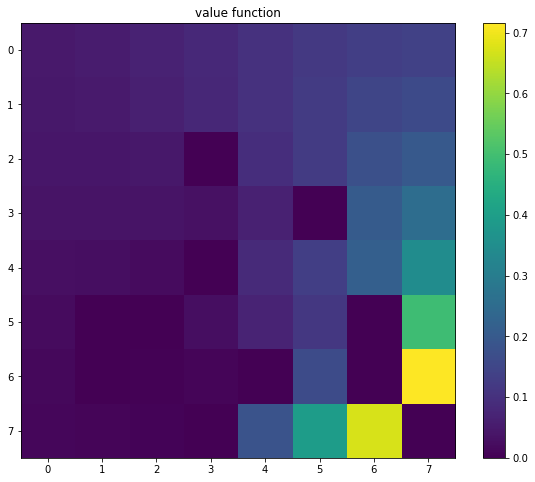

In [40]:
plot_value(v)

In [41]:
info = stats(env, pi)
print(f"the model was evaluate on a total of {info['episodes']} episodes")
print(f"the agent succeeded {info['success']} times")
print(f"the agent failed {info['failure']} times")
print(f"success rate : {info['rate'] * 100} %")

the model was evaluate on a total of 1000 episodes
the agent succeeded 741 times
the agent failed 259 times
success rate : 74.1 %


## 2. Value iteration

In [49]:
def value_iteration(env):
    v = np.zeros(env.nS)
    pi = np.zeros(env.nS, int)
    error = []
    while True:
        delta = 0
        for s in range(env.nS):
            temp = v[s]
            for a in range(env.nA):
                v[s] = max(v[s], one_step_lookahead(env, v, s, a))
            delta = max(delta, abs(v[s] - temp))
        if delta < tol:
            break
        error.append(delta)
    pi, _ = policy_improvement(env,pi,v)
    return v, pi, error 

In [50]:
v, pi, error = value_iteration(env)

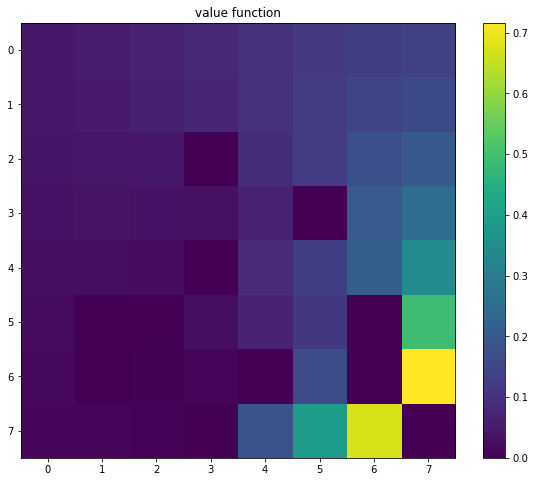

In [45]:
plot_value(v)

Text(0, 0.5, 'error')

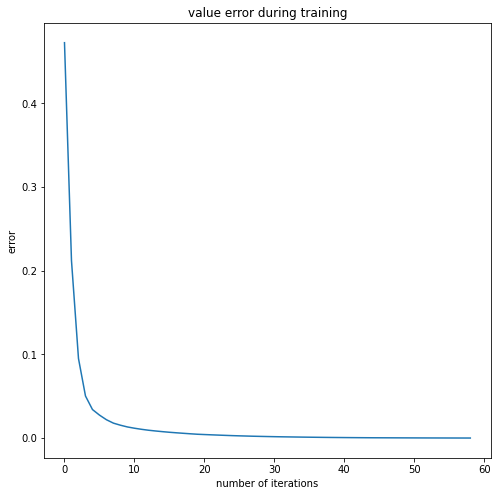

In [53]:
plt.figure(figsize=(8,8))
plt.plot(error)
plt.title("value error during training")
plt.xlabel("number of iterations")
plt.ylabel("error")

In [46]:
info = stats(env, pi)
print(f"the model was evaluate on a total of {info['episodes']} episodes")
print(f"the agent succeeded {info['success']} times")
print(f"the agent failed {info['failure']} times")
print(f"success rate : {info['rate'] * 100} %")

the model was evaluate on a total of 1000 episodes
the agent succeeded 770 times
the agent failed 230 times
success rate : 77.0 %


In [47]:
play(env, pi)

EPISODE  3 

  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
